# Working with Weighted Directed Input Networks in NetREm
## Converting Weighted Directed Networks to Undirected Similarity Networks :)
### By: Saniya Khullar, Xiang Huang, Raghu Ramesh, John Svaren, Daifeng Wang

The code for NetREm is optimized for undirected, weighted, networks.


Please note that in this Jupyter notebook, we will go through how to work with directed prior network graphs in NetREm (Network Regression Embeddings).

There are many ways to do this. 1 of the ways is via the popular graph embedding method of weighted node2vec, where we learn embeddings for each of the nodes based on a random walk followed by a Skipgram model. Hopefully these embeddings capture as much information about the original directed graph network. 

This is similar to the word2vec approach in Natural Language Processing (NLP) tasks.
Then, we will calculate the similarity among nodes based on the cosine similarity values of their embeddings. Ultimately, we will build out an undirected, weighted network among the predictors, which is a similarity network. 

This similarity network may be our input network for NetREm as it is undirected and weighted :)

In [1]:
printdf = lambda *args, **kwargs: print(pd.DataFrame(*args, **kwargs))
rng_seed = 2023 # random seed for reproducibility
randSeed = 123
from packages_needed import *
import error_metrics as em 
from packages_needed import *
import Netrem_model_builder as nm
import DemoDataBuilderXandY as demo
import PriorGraphNetwork as graph
import netrem_evaluation_functions as nm_eval
import essential_functions as ef

In [2]:
# Create a small fake weighted directed network of 10 nodes "TF1 to TF10"
# Given by a DataFrame of [source, target, weight]
data = {
    'source': ["TF1", "TF2", "TF3", "TF3", "TF4", 
               "TF5", "TF6", "TF7", "TF8", "TF9"],
    'target': ["TF2", "TF3", "TF4", "TF5", "TF6",
               "TF7", "TF8", "TF9", "TF10", "TF1"],
    'weight': [0.4, 0.7, 0.2, 0.8, 0.5, 
               0.6, 0.3, 0.9, 0.1, 0.7]
}

df = pd.DataFrame(data)
# Convert the DataFrame to a list of edge tuples
edge_list = [list(x) for x in df.to_records(index=False)]
edge_list

[['TF1', 'TF2', 0.4],
 ['TF2', 'TF3', 0.7],
 ['TF3', 'TF4', 0.2],
 ['TF3', 'TF5', 0.8],
 ['TF4', 'TF6', 0.5],
 ['TF5', 'TF7', 0.6],
 ['TF6', 'TF8', 0.3],
 ['TF7', 'TF9', 0.9],
 ['TF8', 'TF10', 0.1],
 ['TF9', 'TF1', 0.7]]

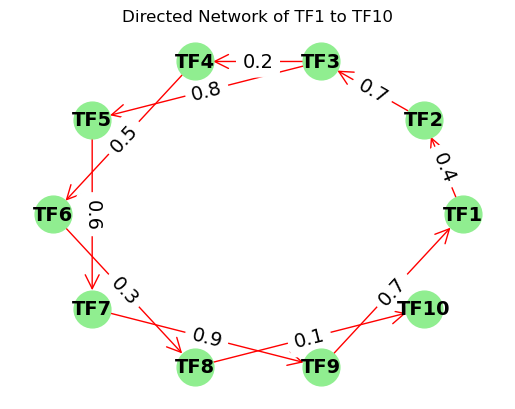

In [3]:
# Create a directed graph
G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], 
                            create_using=nx.DiGraph())

# Generate layout
#pos = nx.spring_layout(G, seed=42)
pos = nx.circular_layout(G)

# Explicitly create a new figure
fig, ax = plt.subplots()

# Draw nodes, edges, and labels
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=700, font_size=14,
        font_color='black', font_weight='bold', edge_color='red', ax=ax,
        arrowstyle='->', arrowsize=25)

# Draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14)

# Show plot
plt.title("Directed Network of TF1 to TF10")
plt.show()

 Given an edge list and node2vec parameters, the directed_node2vec_similarity function in the PriorGraphNetwork class (imported as *graph*) returns a scaled similarity matrix for the node embeddings generated by training a node2vec model on the directed graph defined by the edge list.

**directed_node2vec_similarity**(edge_list: List[Tuple[int, int, float]],
                                                 dimensions: int = 64,
                                                 walk_length: int = 30,
                                                 num_walks: int = 200,
                                                 p: float = 1, q: float = 0.5,
                                                 workers: int = 4, window: int = 10,
                                                 min_count: int = 1,
                                                 batch_words: int = 4) -> np.ndarray:
                                                 
                                                 

Parameters:
-----------
    edge_list: List[List[int, int, float]]
        A list of lists representing the edges of a directed graph. Each edge should be a list of three values:
        [source_node, target_node, edge_weight]. If no edge weight is specified, it is assumed to be 1.0.

    dimensions: int, optional (default=64)
        The dimensionality of the node embeddings.

    walk_length: int, optional (default=30)
        The length of each random walk during the node2vec training process.

    num_walks: int, optional (default=200)
        The number of random walks to generate for each node during the node2vec training process.

    p: float, optional (default=1)
        The return parameter for the node2vec algorithm.

    q: float, optional (default=0.5)
        The in-out parameter for the node2vec algorithm.

    workers: int, optional (default=4)
        The number of worker threads to use during the node2vec training process.

    window: int, optional (default=10)
        The size of the window for the skip-gram model during training.

    min_count: int, optional (default=1)
        The minimum count for a word in the training data to be included in the model.

    batch_words: int, optional (default=4)
        The number of words in each batch during training.

We run this function below to retrieve the similarity matrix values for our nodes. 

In [4]:
results_dict = graph.directed_node2vec_similarity(edge_list)


directed_node2vec_similarity
Creating directed graph from edge list
Initializing the Node2Vec model


Computing transition probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Training the model
Getting node embeddings
Calculating cosine similarity matrix
Scaling similarity matrix to 0-1 range
:) First 5 entries of the symmetric similarity matrix for 10 nodes.
          TF1       TF2       TF3       TF4       TF5
TF1  1.000000  0.977565  0.982839  0.791959  0.977899
TF2  0.977565  1.000000  0.979204  0.807541  0.981714
TF3  0.982839  0.979204  1.000000  0.812772  0.982637
TF4  0.791959  0.807541  0.812772  1.000000  0.729563
TF5  0.977899  0.981714  0.982637  0.729563  1.000000

 :) ######################################################## 

:) Please note that we return a dictionary with 3 keys based on Node2Vec and cosine similarity computations:
1. similarity_matrix: the cosine similarity matrix for the nodes in the original directed graph
2. similarity_df: simplified dataframe of the cosine similarity values from the similarity_matrix.
3. NetREm_edgelist: an edge_list that is based on similarity_df that is ready to be input for NetREm.
dict_keys(['similar

In [5]:
results_dict["similarity_matrix"]

,TF1,TF2,TF3,TF4,TF5,TF6,TF7,TF8,TF9,TF10
TF1,1.000000,0.977565,0.982839,0.791959,0.977899,0.775640,0.967170,0.735392,0.948157,0.751666
TF2,0.977565,1.000000,0.979204,0.807541,0.981714,0.789227,0.958244,0.765684,0.974940,0.767854
TF3,0.982839,0.979204,1.000000,0.812772,0.982637,0.785401,0.984694,0.756441,0.976156,0.772716
TF4,0.791959,0.807541,0.812772,1.000000,0.729563,0.984206,0.759797,0.987939,0.761482,0.987777
TF5,0.977899,0.981714,0.982637,0.729563,1.000000,0.699416,0.982236,0.672345,0.983200,0.681467
TF6,0.775640,0.789227,0.785401,0.984206,0.699416,1.000000,0.726584,0.983813,0.727340,0.989362
TF7,0.967170,0.958244,0.984694,0.759797,0.982236,0.726584,1.000000,0.698695,0.978932,0.712766
TF8,0.735392,0.765684,0.756441,0.987939,0.672345,0.983813,0.698695,1.000000,0.714580,0.984900
TF9,0.948157,0.974940,0.976156,0.761482,0.983200,0.727340,0.978932,0.714580,1.000000,0.712718
TF10,0.751666,0.767854,0.772716,0.987777,0.681467,0.989362,0.712766,0.984900,0.712718,1.000000


In [6]:
similarity_df = results_dict["similarity_df"]
similarity_df

,node_1,node_2,cosine_similarity
1,TF2,TF1,0.977565
2,TF3,TF1,0.982839
3,TF4,TF1,0.791959
4,TF5,TF1,0.977899
5,TF6,TF1,0.775640
...,...,...,...
94,TF5,TF10,0.681467
95,TF6,TF10,0.989362
96,TF7,TF10,0.712766
97,TF8,TF10,0.984900


In [7]:
undirected_edge_list = results_dict["NetREm_edgelist"]
undirected_edge_list

[['TF2', 'TF1', 0.9775652289390564],
 ['TF3', 'TF1', 0.9828392863273621],
 ['TF4', 'TF1', 0.791959285736084],
 ['TF5', 'TF1', 0.9778987169265747],
 ['TF6', 'TF1', 0.7756398320198059],
 ['TF7', 'TF1', 0.9671704173088074],
 ['TF8', 'TF1', 0.7353924512863159],
 ['TF9', 'TF1', 0.9481567144393921],
 ['TF10', 'TF1', 0.7516655921936035],
 ['TF1', 'TF2', 0.9775652289390564],
 ['TF3', 'TF2', 0.9792038202285767],
 ['TF4', 'TF2', 0.807540774345398],
 ['TF5', 'TF2', 0.9817137718200684],
 ['TF6', 'TF2', 0.7892271280288696],
 ['TF7', 'TF2', 0.9582439661026001],
 ['TF8', 'TF2', 0.7656841278076172],
 ['TF9', 'TF2', 0.9749403595924377],
 ['TF10', 'TF2', 0.7678544521331787],
 ['TF1', 'TF3', 0.9828392863273621],
 ['TF2', 'TF3', 0.9792038202285767],
 ['TF4', 'TF3', 0.8127720355987549],
 ['TF5', 'TF3', 0.9826374053955078],
 ['TF6', 'TF3', 0.7854012846946716],
 ['TF7', 'TF3', 0.9846940636634827],
 ['TF8', 'TF3', 0.7564405202865601],
 ['TF9', 'TF3', 0.9761558771133423],
 ['TF10', 'TF3', 0.7727159261703491],


We can visualize this updated undirected network of cosine similarities, which we can input to NetREm. :)

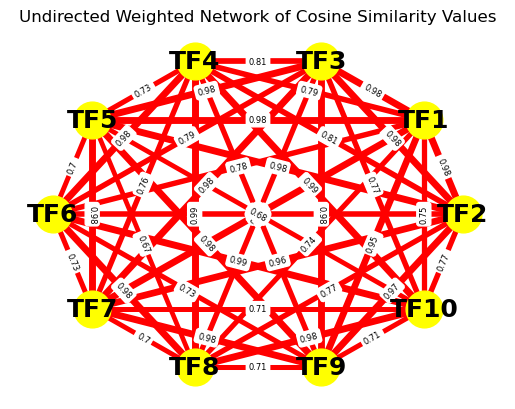

In [8]:
# Create an undirected graph
G = nx.Graph()

# Add edges to the graph
for _, row in similarity_df.iterrows():
    G.add_edge(row['node_1'], row['node_2'], weight=row['cosine_similarity'])

# Generate layout
pos = nx.circular_layout(G)
# Get edge weights and normalize for better visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
normalized_weights = [5 * (weight / max_weight) 
                      for weight in edge_weights]  # multiplied by 5 for better visibility

# Explicitly create a new figure and axes
fig, ax = plt.subplots()

# Draw nodes, edges, and labels
nx.draw(G, pos, with_labels=True, node_color='yellow',
        node_size=700, font_size=18,
        font_color='black', font_weight='bold', 
        edge_color='red', width=normalized_weights, ax=ax)

# Draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
for label in labels:
    labels[label] = round(labels[label], 2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, 
                             font_size=6, ax=ax)

# Show plot
plt.title("Undirected Weighted Network of Cosine Similarity Values")
plt.show()

We can compare the original directed network weights (*directed_weight* values) with the updated cosine similarity undirected values (*cosine_similarity*) as we do below:

In [15]:
directed_wieghts_df = df
directed_wieghts_df = directed_wieghts_df.rename(columns = {"source":"node_1", "target":"node_2",
                                                           "weight":"directed_weight"})
directed_wieghts_df
comparison_df = pd.merge(similarity_df, directed_wieghts_df, how = "left", on = ["node_1", "node_2"])
comparison_df = comparison_df.fillna(0)
comparison_df = comparison_df.sort_values(by = ["directed_weight"], ascending = False)
comparison_df

,node_1,node_2,cosine_similarity,directed_weight
78,TF7,TF9,0.978932,0.9
38,TF3,TF5,0.982637,0.8
7,TF9,TF1,0.948157,0.7
19,TF2,TF3,0.979204,0.7
58,TF5,TF7,0.982236,0.6
...,...,...,...,...
31,TF6,TF4,0.984206,0.0
30,TF5,TF4,0.729563,0.0
28,TF2,TF4,0.807541,0.0
27,TF1,TF4,0.791959,0.0
